In [1]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from evaluation import n_precision_at_recall_for_query, precision_at_recall_for_query, tnr_at_recall_for_query, find_last_relevant_for_query, mean_average_precision_for_query

%matplotlib inline

In [2]:
runs = pickle.load(open('../data/0_external/runs.pkl', 'rb'))

In [3]:
print(f"runs: {len(runs)}")
print(f"topics: {len(runs['bm25_abstract'])}")

runs: 24
topics: 100


In [4]:
qrels = pickle.load(open('../data/0_external/qrels.pkl', 'rb'))

In [7]:
df = pd.DataFrame()
for run_name, run in runs.items():
    scores_dict = {}
    print(run_name)
    for query_id, rankings in run.items():
        scores_dict[query_id] = {}
        scores_dict[query_id]['model'] = run_name
        qrels_for_query = qrels[query_id]
        scores_dict[query_id]['nP@95%'] = n_precision_at_recall_for_query(rankings=rankings, qrels=qrels_for_query, recall_level=0.95)
        scores_dict[query_id]['P@95%'] = precision_at_recall_for_query(rankings=rankings, qrels=qrels_for_query, recall_level=0.95)
        scores_dict[query_id]['TNR@95%'] = tnr_at_recall_for_query(rankings=rankings, qrels=qrels_for_query, recall_level=0.95)
        scores_dict[query_id]['last_rel'] = find_last_relevant_for_query(rankings=rankings, qrels=qrels_for_query)
        scores_dict[query_id]['MAP'] = mean_average_precision_for_query(rankings=rankings, qrels=qrels_for_query)
        
        scores_dict[query_id]['Dataset size'] = len(rankings)
        scores_dict[query_id]['%Irrelevant'] = list(qrels_for_query.values()).count(0) / len(qrels_for_query)
        scores_dict[query_id]['%Relevant'] = list(qrels_for_query.values()).count(1) / len(qrels_for_query)
    print(len(df))
    df = pd.concat([df, pd.DataFrame(scores_dict).T])

bm25_abstract
0
bm25_title
100
bm25_query
200
bm25_criteria
300
tf-idf_abstract
400
tf-idf_title
500
tf-idf_query
600
tf-idf_criteria
700
MiniLM-256_abstract
800
MiniLM-256_title
900
MiniLM-256_query
1000
MiniLM-256_criteria
1100
mpnet_abstract
1200
mpnet_title
1300
mpnet_query
1400
mpnet_criteria
1500
S-BioBert_abstract
1600
S-BioBert_title
1700
S-BioBert_query
1800
S-BioBert_criteria
1900
pubmedbert_abstract
2000
pubmedbert_title
2100
pubmedbert_query
2200
pubmedbert_criteria
2300


In [8]:
average_tnr = df.groupby("model")["TNR@95%"].mean().mean()
average_np = df.groupby("model")["nP@95%"].mean().mean()
average_p = df.groupby("model")["P@95%"].mean().mean()
average_last_rel = df.groupby("model")["last_rel"].mean().mean()
average_map = df.groupby("model")["MAP"].mean().mean()

# Correlation Analysis between nP@95% and other metrics

In [12]:
print(df[['nP@95%', 'P@95%', 'TNR@95%', 'last_rel', "MAP", 'Dataset size', '%Irrelevant', '%Relevant']].corr("spearman").round(3).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
 & nP@95% & P@95% & TNR@95% & last_rel & MAP & Dataset size & %Irrelevant & %Relevant \\
\midrule
nP@95% & 1.000000 & 0.625000 & 0.703000 & -0.547000 & 0.256000 & -0.251000 & -0.084000 & 0.084000 \\
P@95% & 0.625000 & 1.000000 & 0.079000 & 0.087000 & 0.788000 & -0.651000 & -0.662000 & 0.662000 \\
TNR@95% & 0.703000 & 0.079000 & 1.000000 & -0.898000 & -0.381000 & 0.254000 & 0.548000 & -0.548000 \\
last_rel & -0.547000 & 0.087000 & -0.898000 & 1.000000 & 0.494000 & -0.246000 & -0.646000 & 0.646000 \\
MAP & 0.256000 & 0.788000 & -0.381000 & 0.494000 & 1.000000 & -0.755000 & -0.948000 & 0.948000 \\
Dataset size & -0.251000 & -0.651000 & 0.254000 & -0.246000 & -0.755000 & 1.000000 & 0.759000 & -0.759000 \\
%Irrelevant & -0.084000 & -0.662000 & 0.548000 & -0.646000 & -0.948000 & 0.759000 & 1.000000 & -1.000000 \\
%Relevant & 0.084000 & 0.662000 & -0.548000 & 0.646000 & 0.948000 & -0.759000 & -1.000000 & 1.000000 \\
\bottomrule
\end{tabular}


In [43]:
sns.set_theme(style="whitegrid")

# Plot of nP@95% vs TNR@95%

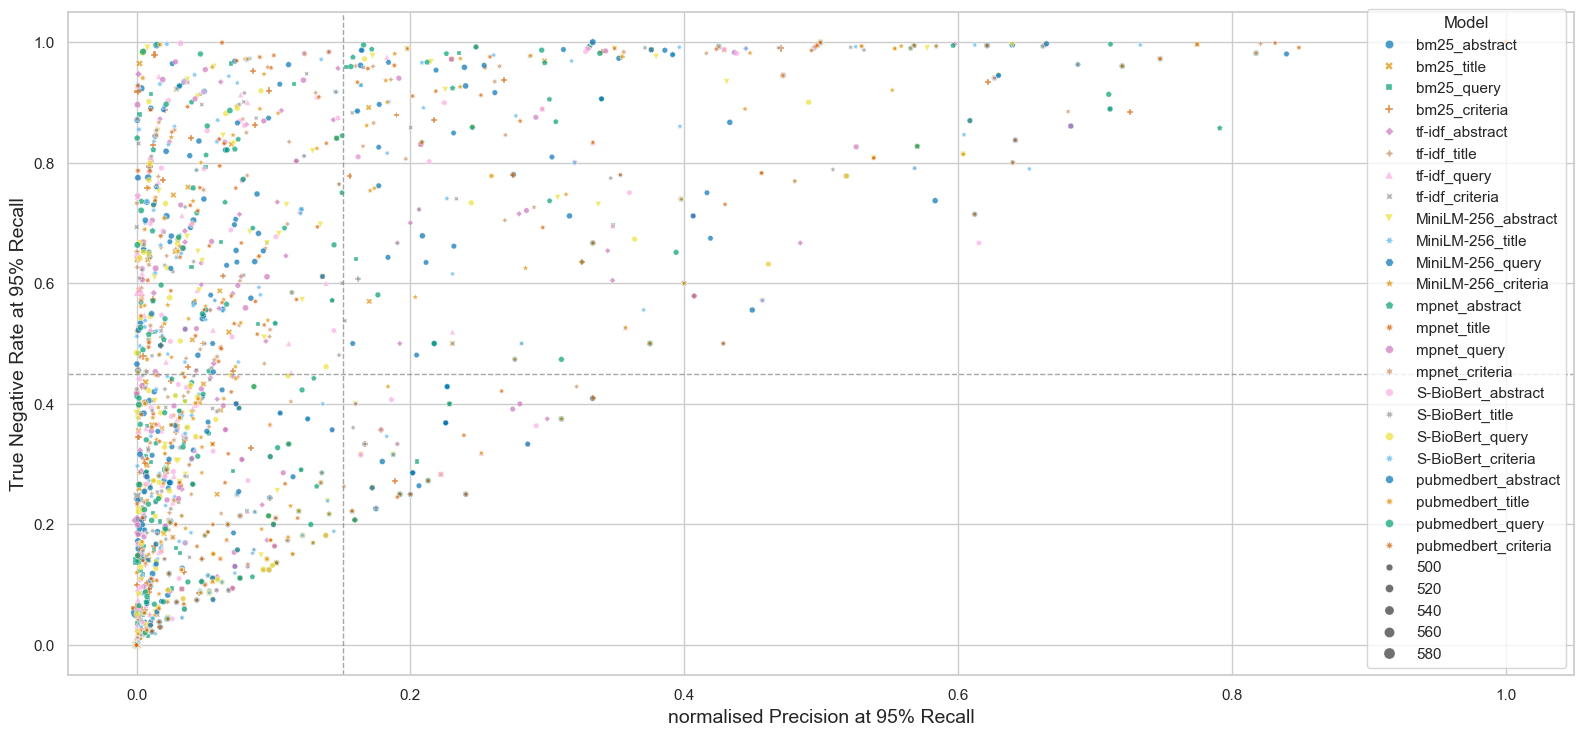

In [49]:
plt.figure(figsize=(16, 8))  # You can adjust the dimensions as needed

min_marker_size = 35  # Minimum marker size
max_marker_size = 140  # Maximum marker size
data_size_normalised = (df['Dataset size'] - df['Dataset size'].min()) / (df['Dataset size'].max() - df['Dataset size'].min())
marker_sizes = min_marker_size + (max_marker_size - min_marker_size) * data_size_normalised

marker_sizes = marker_sizes.astype(float)

# Create the scatterplot
ax = sns.scatterplot(
    data=df,
    x="nP@95%",
    y="TNR@95%",
    hue="model",
    palette="colorblind",  # Using a colorblind-friendly palette
    style="model",  # Different marker styles for each model
    size=marker_sizes.tolist(),  # Adjust the size of the markers
    alpha=0.7  # Set transparency to avoid overplotting
)

# Add enhancements
plt.xlabel('normalised Precision at 95% Recall', fontsize=14)
plt.ylabel('True Negative Rate at 95% Recall', fontsize=14)
ax.legend(title="Model", loc='lower right')  # Move the legend outside the plot

# Add reference lines if necessary set width of lines to 0.5
ax.axhline(y=average_tnr, color='gray', linestyle='--', label='Avg. TNR', alpha=0.7, linewidth=1)
ax.axvline(x=average_np, color='gray', linestyle='--', label='Avg. nP', alpha=0.7, linewidth=1)

# Save the figure
plt.tight_layout()
plt.savefig("../reports/nP_at_95_vs_TNR_at_951.pdf", dpi=300)


# Bland-Altman plot

In [60]:
# plot Bland-Altman Plot: This plot can be used to assess the agreement between nP@95% and TNR@95% for each model. It will help to visualize the extent of disagreement (bias) and the pattern of this disagreement across the range of measurements.

def bland_altman_plot(data1, data2, labels, data_sizes, *args, **kwargs):
    """
    Bland-Altman Plot.
    
    A Bland-Altman plot is a graphical method to analyze the differences 
    between two methods of measurement. The mean of the measures is plotted 
    against their difference.

    Parameters:
    - data1, data2: Arrays of the two sets of measurements to be compared.
    - labels : list Labels of the two sets of measurements. E.g. model name
    """
    min_marker_size = 35  # Minimum marker size
    max_marker_size = 140  # Maximum marker size
    data_size_normalised = (data_sizes - data_sizes.min()) / (data_sizes.max() - data_sizes.min())
    marker_sizes = min_marker_size + (max_marker_size - min_marker_size) * data_size_normalised


    data1 = np.asarray(data1)
    data2 = np.asarray(data2)
    
    # Calculate means and differences
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2
    md = np.mean(diff)
    sd = np.std(diff, axis=0)
    
    # Create plot
    plt.figure(figsize=(8, 5))
    
    # color items by labels. labels is a list of strings with the same length as data1 and data2
    sns.scatterplot(x=mean, y=diff, *args, **kwargs, hue=labels, style=labels, palette="colorblind",
                    size=marker_sizes, alpha=0.7)
    
    plt.axhline(md, color='cadetblue', linestyle='--', alpha=0.7, linewidth=1.5)
    plt.axhline(md + 1.96*sd, color='salmon', linestyle='--', alpha=0.7, linewidth=1)
    plt.axhline(md - 1.96*sd, color='salmon', linestyle='--', alpha=0.7, linewidth=1)

    plt.text(mean.max(), md, 'Mean', va='bottom', ha='right', color='cadetblue', alpha=0.7)
    plt.text(mean.max(), md + 1.96*sd, '+1.96 SD', va='bottom', ha='right', color='salmon', alpha=0.7)
    plt.text(mean.max(), md - 1.96*sd, '-1.96 SD', va='bottom', ha='right', color='salmon', alpha=0.7)

    # add legend
    # handles, _ = ax.get_legend_handles_labels()
    # ax.legend(handles, labels)

    plt.xlabel('Mean of Two Measures', fontsize=14)
    plt.ylabel('Difference Between Two Measures', fontsize=14)
    
    # turn off legend
    plt.legend([],[], frameon=False)

    plt.tight_layout()
    plt.savefig("../reports/bland_altman_plot.pdf", dpi=300)


# Example usage
# data1 = [your_data_set_1]
# data2 = [your_data_set_2]
# bland_altman_plot(data1, data2)

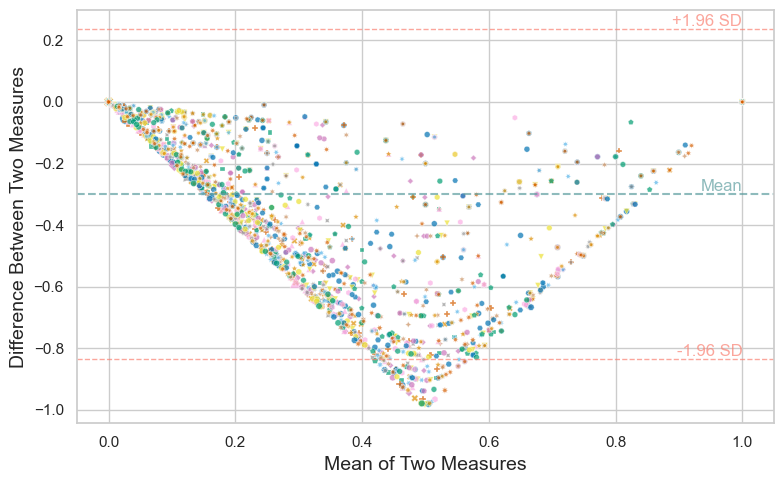

In [61]:
bland_altman_plot(df["nP@95%"], df["TNR@95%"], labels=df["model"].tolist(),
                  data_sizes=df["Dataset size"])